# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_50', 'ORACLE.run2_32', 'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_8', 'ORACLE.run2_20', 'ORACLE.run2_38'}


{'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_38', 'ORACLE.run1_26'}


tensor([[[-1.0303, -0.2991,  1.2297,  ...,  0.1757, -0.6315,  1.0825],
         [ 0.0142, -0.5650, -0.1187,  ...,  0.7929,  1.0873,  0.7264]],

        [[-0.8001,  0.1572,  1.0477,  ..., -0.5477, -1.0001,  0.6905],
         [-0.7286, -0.5477,  0.6858,  ...,  0.7334,  0.4810,  1.2572]],

        [[-0.1614,  1.0631, -0.1329,  ..., -0.9539,  0.3275,  0.1186],
         [-0.2753,  0.1803,  0.5363,  ...,  0.1376, -1.0583, -1.1247]],

        ...,

        [[ 0.9156, -0.4391, -1.0227,  ...,  0.7228,  0.9424, -0.6747],
         [ 0.7175,  0.4926, -0.6158,  ..., -0.7443, -0.5140, -1.2422]],

        [[-0.2035, -1.1141,  0.5517,  ...,  1.0123, -0.7445, -0.1285],
         [ 0.3160, -0.4981, -0.4821,  ...,  0.3321,  1.0284,  0.9909]],

        [[-0.1791,  0.8247,  0.2496,  ..., -0.6023, -0.7922, -1.0038],
         [-0.4069, -0.9984,  0.7596,  ...,  0.6891, -1.0472, -0.1574]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.4534, train_label_loss: 2.7923, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2660.1769, train_label_loss: 1.1875, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2858.3762, train_label_loss: 0.8199, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2991.7991, train_label_loss: 1.2321, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2726.9840, train_label_loss: 0.5153, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3105.8845, train_label_loss: 0.4515, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3136.6511, train_label_loss: 0.4804, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2520.6717, train_label_loss: 0.6256, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2302.2920, train_label_loss: 0.2528, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2296.1644, train_label_loss: 0.3543, 


epoch: 1, source_val_acc_label: 0.7354, target_val_acc_label: 0.7426, source_val_label_loss: 0.8435, target_val_label_loss: 0.8670, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.0024, train_label_loss: 1.1118, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2480.2921, train_label_loss: 0.3100, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2571.7694, train_label_loss: 1.0275, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2760.8585, train_label_loss: 0.3294, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2320.2077, train_label_loss: 0.3276, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2586.3573, train_label_loss: 0.4820, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2609.4955, train_label_loss: 0.1427, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2536.9758, train_label_loss: 1.0964, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2296.1841, train_label_loss: 0.8407, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2291.4377, train_label_loss: 0.4013, 


epoch: 2, source_val_acc_label: 0.8229, target_val_acc_label: 0.8233, source_val_label_loss: 0.5030, target_val_label_loss: 0.4958, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 1.9991, train_label_loss: 0.6826, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2534.4550, train_label_loss: 0.3487, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2602.4102, train_label_loss: 0.2786, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2572.0033, train_label_loss: 0.5766, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2341.2805, train_label_loss: 0.1335, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2544.7399, train_label_loss: 0.1660, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2562.8417, train_label_loss: 0.4244, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2533.1259, train_label_loss: 0.4881, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2291.4414, train_label_loss: 0.6771, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2305.4881, train_label_loss: 0.2946, 


epoch: 3, source_val_acc_label: 0.8521, target_val_acc_label: 0.8470, source_val_label_loss: 0.4058, target_val_label_loss: 0.4215, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 1.9924, train_label_loss: 0.1425, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2574.3743, train_label_loss: 0.0884, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2584.8271, train_label_loss: 0.5801, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2527.6166, train_label_loss: 0.0459, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2431.4575, train_label_loss: 0.4898, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2587.2683, train_label_loss: 0.1328, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2531.4590, train_label_loss: 0.4028, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2542.4075, train_label_loss: 0.4767, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2577.2615, train_label_loss: 0.2565, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2559.1008, train_label_loss: 0.2340, 


epoch: 4, source_val_acc_label: 0.8794, target_val_acc_label: 0.8730, source_val_label_loss: 0.3317, target_val_label_loss: 0.3540, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.2734, train_label_loss: 0.1990, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2913.5162, train_label_loss: 0.3791, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3033.9819, train_label_loss: 0.1617, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2757.2890, train_label_loss: 0.5031, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2974.6881, train_label_loss: 0.3921, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3182.2488, train_label_loss: 0.5598, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3404.9539, train_label_loss: 0.2609, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3390.7226, train_label_loss: 0.2441, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3418.8073, train_label_loss: 0.0574, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3267.4011, train_label_loss: 0.1532, 


epoch: 5, source_val_acc_label: 0.8870, target_val_acc_label: 0.8773, source_val_label_loss: 0.3106, target_val_label_loss: 0.3452, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.4425, train_label_loss: 0.2631, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3799.3354, train_label_loss: 0.0905, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3273.1109, train_label_loss: 0.1924, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2941.4788, train_label_loss: 0.2206, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2964.4174, train_label_loss: 0.0729, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2947.6601, train_label_loss: 0.0329, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2952.0382, train_label_loss: 0.3934, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2978.0002, train_label_loss: 0.2521, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2299.2494, train_label_loss: 0.1219, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2291.9971, train_label_loss: 0.2473, 


epoch: 6, source_val_acc_label: 0.8903, target_val_acc_label: 0.8813, source_val_label_loss: 0.3019, target_val_label_loss: 0.3361, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.0858, train_label_loss: 0.1524, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2620.0250, train_label_loss: 0.1531, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2386.5959, train_label_loss: 0.4431, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2292.3485, train_label_loss: 0.3241, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2275.0154, train_label_loss: 0.0716, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2459.2908, train_label_loss: 0.0866, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2585.4586, train_label_loss: 0.0728, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2540.5986, train_label_loss: 0.0705, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2560.0754, train_label_loss: 0.2144, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2577.3933, train_label_loss: 0.0731, 


epoch: 7, source_val_acc_label: 0.8876, target_val_acc_label: 0.8776, source_val_label_loss: 0.3083, target_val_label_loss: 0.3499, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.4499, train_label_loss: 0.2254, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2609.2567, train_label_loss: 0.3060, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2292.4616, train_label_loss: 0.2288, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2318.9644, train_label_loss: 0.2895, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2308.4123, train_label_loss: 0.1908, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2319.2645, train_label_loss: 0.7206, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2328.0313, train_label_loss: 0.0686, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2300.3328, train_label_loss: 0.1332, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2310.8114, train_label_loss: 0.1270, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2307.3987, train_label_loss: 0.3652, 


epoch: 8, source_val_acc_label: 0.8950, target_val_acc_label: 0.8819, source_val_label_loss: 0.2867, target_val_label_loss: 0.3342, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.3333, train_label_loss: 0.1208, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2905.0074, train_label_loss: 0.4880, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2570.6397, train_label_loss: 0.1930, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2546.3310, train_label_loss: 0.0742, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2615.1089, train_label_loss: 0.3432, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2592.2253, train_label_loss: 0.1403, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2319.5534, train_label_loss: 0.6110, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2284.4271, train_label_loss: 0.0411, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2287.4617, train_label_loss: 0.1786, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2296.5419, train_label_loss: 0.1375, 


epoch: 9, source_val_acc_label: 0.8937, target_val_acc_label: 0.8782, source_val_label_loss: 0.2891, target_val_label_loss: 0.3491, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.1995, train_label_loss: 0.1628, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2910.6412, train_label_loss: 0.1640, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2866.3823, train_label_loss: 0.0905, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3252.6035, train_label_loss: 0.1017, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3217.8494, train_label_loss: 0.1521, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3315.6151, train_label_loss: 0.2011, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3191.7593, train_label_loss: 0.2428, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3782.0143, train_label_loss: 0.1304, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3423.0408, train_label_loss: 0.1838, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3297.1110, train_label_loss: 0.0289, 


epoch: 10, source_val_acc_label: 0.8946, target_val_acc_label: 0.8807, source_val_label_loss: 0.2854, target_val_label_loss: 0.3406, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.8102, train_label_loss: 0.0300, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2937.3519, train_label_loss: 0.4353, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2862.9097, train_label_loss: 0.1218, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2978.9103, train_label_loss: 0.1401, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2972.5376, train_label_loss: 0.0720, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2962.8670, train_label_loss: 0.3043, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2932.6957, train_label_loss: 0.2092, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3090.0149, train_label_loss: 0.1054, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3426.8447, train_label_loss: 0.0861, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3420.4353, train_label_loss: 0.1900, 


epoch: 11, source_val_acc_label: 0.8875, target_val_acc_label: 0.8705, source_val_label_loss: 0.3165, target_val_label_loss: 0.3759, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.0642, train_label_loss: 0.1170, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3684.5961, train_label_loss: 0.0177, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3044.5057, train_label_loss: 0.4134, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2995.2359, train_label_loss: 0.1458, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2980.5380, train_label_loss: 0.1809, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3048.8192, train_label_loss: 0.3500, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3002.2401, train_label_loss: 0.1079, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3005.0983, train_label_loss: 0.1226, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2948.0611, train_label_loss: 0.1024, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2944.2674, train_label_loss: 0.2668, 


epoch: 12, source_val_acc_label: 0.9044, target_val_acc_label: 0.8848, source_val_label_loss: 0.2652, target_val_label_loss: 0.3347, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.8316, train_label_loss: 0.1420, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3327.3221, train_label_loss: 0.4225, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3398.1536, train_label_loss: 0.1930, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3409.1035, train_label_loss: 0.0912, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3335.3946, train_label_loss: 0.0979, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3467.0929, train_label_loss: 0.1324, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3348.1610, train_label_loss: 0.3830, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2956.2739, train_label_loss: 0.0853, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2980.1399, train_label_loss: 0.2058, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2967.4657, train_label_loss: 0.1513, 


epoch: 13, source_val_acc_label: 0.9030, target_val_acc_label: 0.8866, source_val_label_loss: 0.2708, target_val_label_loss: 0.3364, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.7550, train_label_loss: 0.0666, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2943.9693, train_label_loss: 0.0451, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2954.5695, train_label_loss: 0.3351, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3081.7563, train_label_loss: 0.1007, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3414.5292, train_label_loss: 0.0901, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3457.9057, train_label_loss: 0.0042, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3394.2469, train_label_loss: 0.0505, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3555.2802, train_label_loss: 0.1052, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3753.2752, train_label_loss: 0.0235, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3628.4681, train_label_loss: 0.4718, 


epoch: 14, source_val_acc_label: 0.9040, target_val_acc_label: 0.8824, source_val_label_loss: 0.2721, target_val_label_loss: 0.3605, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.6256, train_label_loss: 0.3938, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 4123.4974, train_label_loss: 0.1750, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 4457.8729, train_label_loss: 0.0684, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3741.2695, train_label_loss: 0.1069, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3419.8339, train_label_loss: 0.0356, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3386.0136, train_label_loss: 0.0027, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3431.8914, train_label_loss: 0.1964, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3389.9638, train_label_loss: 0.0150, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3422.4948, train_label_loss: 0.1472, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3432.3330, train_label_loss: 0.0949, 


epoch: 15, source_val_acc_label: 0.8971, target_val_acc_label: 0.8801, source_val_label_loss: 0.2882, target_val_label_loss: 0.3608, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 3.1671, train_label_loss: 0.3060, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3396.8504, train_label_loss: 0.0192, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3481.0755, train_label_loss: 0.1280, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3467.1480, train_label_loss: 0.1350, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3432.2064, train_label_loss: 0.0633, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3394.9417, train_label_loss: 0.1626, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3432.8371, train_label_loss: 0.0782, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3450.4956, train_label_loss: 0.2194, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3412.7038, train_label_loss: 0.1833, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3515.4957, train_label_loss: 0.0320, 


epoch: 16, source_val_acc_label: 0.9039, target_val_acc_label: 0.8853, source_val_label_loss: 0.2769, target_val_label_loss: 0.3495, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.9164, train_label_loss: 0.0590, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3840.0915, train_label_loss: 0.0117, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3904.0643, train_label_loss: 0.5237, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3978.2862, train_label_loss: 0.0835, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3954.9824, train_label_loss: 0.0168, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 4006.2520, train_label_loss: 0.0672, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 4061.1017, train_label_loss: 0.1794, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 4023.7064, train_label_loss: 0.0440, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3925.8097, train_label_loss: 0.0154, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3909.5878, train_label_loss: 0.1546, 


epoch: 17, source_val_acc_label: 0.9013, target_val_acc_label: 0.8801, source_val_label_loss: 0.2924, target_val_label_loss: 0.3835, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

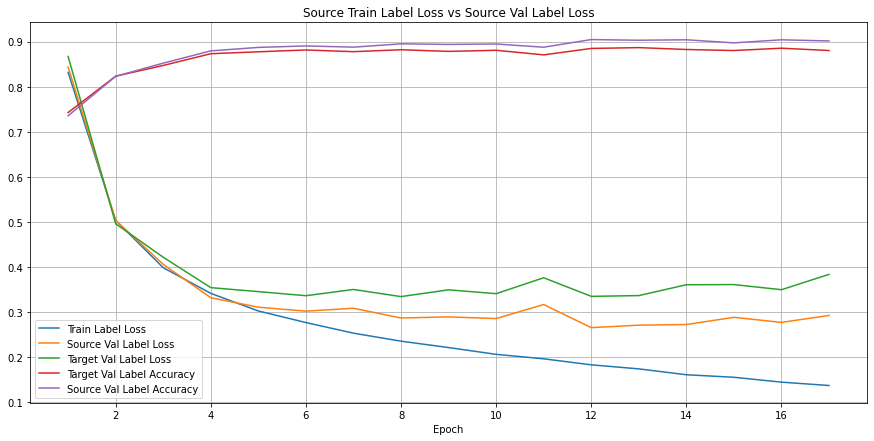

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

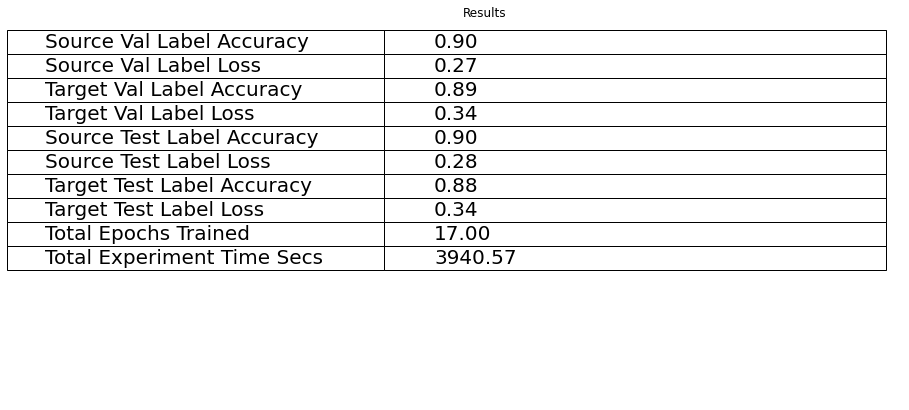

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

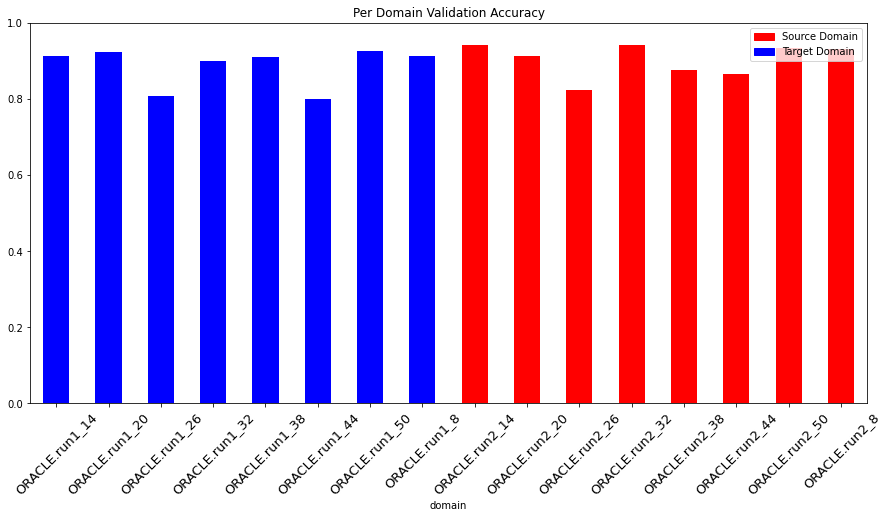

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9025716145833333 Target Test Label Accuracy: 0.884375
Source Val Label Accuracy: 0.9029622395833333 Target Val Label Accuracy: 0.8865885416666667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048